In [288]:
import random
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from tools import MetricsHistory
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt 

In [151]:
#import data
X_data_dir = r"D:\Studia\ISA-magister\sem_1\Algorytmy_optymalizacji\Projekt\Repo\nn-arc-optimization\output_files\X_scaled.csv"
y_data_dir = r"D:\Studia\ISA-magister\sem_1\Algorytmy_optymalizacji\Projekt\Repo\nn-arc-optimization\output_files\y.csv"

X_data = pd.read_csv(X_data_dir)
y_data = pd.read_csv(y_data_dir)

x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

In [190]:
#define populatio size (num. of networks)
pupulation_size = 4

#define generations
generations = 10

#define miation propabiliry
mutation_prob = 0.3

#define crossover propability 
cross_prob = 0.5

#define input shape for neural network
Input = 30

all_val_losses = []
all_accuracies = []

In [286]:
def Individual():
    n_layers = random.randint(1,4)
    r_optimizer = random.choice([keras.optimizers.RMSprop(),'adam','sgd'])
    neurons=[]
    for i in range(n_layers):
        neurons.append(random.randint(1,100))
    neurons.sort(reverse=True)
    
    model = Sequential()
    model.add(Dense(30, input_dim=Input, activation='relu'))
    for i in range(n_layers):
        model.add(Dense(neurons[i], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=r_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_population(pupulation_size):
    models = []
    for _ in range(pupulation_size):
        models.append(Individual())
    models = list(set(models))
    return models

def evaluate(individual):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, restore_best_weights=True)
    metrics_history = MetricsHistory()
    history = individual.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=1, verbose=0, callbacks=[es,metrics_history])
    #pupulation[i].save(f'genetic_output_files/genetic_model_initial_individuals{i}.h5')
    all_accuracies.append(metrics_history.accuracy)
    all_val_losses.append(metrics_history.val_loss)
    _, test_accuracy = individual.evaluate(x_test, y_test, verbose=0) 
    return test_accuracy

def selection(population, fitnesses, num_parents):
    sorted_indices = np.argsort(fitnesses)[::-1]
    return [population[i] for i in sorted_indices[:num_parents]]

def crossover(parent1, parent2):
    """Krzyżowanie dwóch rodziców w celu utworzenia dwóch dzieci."""
    parent1_layers = parent1.layers
    parent2_layers = parent2.layers

    point1 = random.randint(1, min(len(parent1_layers), len(parent2_layers)) - 1)
    point2 = random.randint(point1, min(len(parent1_layers), len(parent2_layers)) - 1)

    child1_layers = [layer.get_config() for layer in parent1_layers]
    child2_layers = [layer.get_config() for layer in parent2_layers]

    for i in range(point1, point2):
        child1_layers[i] = parent2_layers[i].get_config()
        child2_layers[i] = parent1_layers[i].get_config()

      # Creating new models
    child1_model = Sequential()
    child2_model = Sequential()

    for layer_config in child1_layers:
        layer = Dense.from_config(layer_config)
        child1_model.add(layer)

    for layer_config in child2_layers:
        layer = Dense.from_config(layer_config)
        child2_model.add(layer)
        
    # Creating new optimizers for child models
    child1_optimizer = parent1.optimizer.__class__.from_config(parent1.optimizer.get_config())
    child2_optimizer = parent2.optimizer.__class__.from_config(parent2.optimizer.get_config())
    # Compiling new models
    child1_model.compile(optimizer=child1_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    child2_model.compile(optimizer=child2_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return child1_model, child2_model

# def mutate(individual):
#     if random.random() < mutation_prob:
#         mutation_type = random.choice(['n_layers', 'neurons', 'optimizer'])
#         if mutation_type == 'n_layers':
#             individual['n_layers'] = random.randint(1, 4)
#         elif mutation_type == 'neurons':
#             individual['neurons'] = [random.randint(1, 100) for _ in range(individual['n_layers'])]
#             individual['neurons'].sort(reverse=True)
#         elif mutation_type == 'optimizer':
#             individual['optimizer'] = random.choice(['rmsprop', 'adam', 'sgd'])
#     return individual


def main():
    population = create_population(pupulation_size)
    
    for generation in range(GENERATIONS):
        print(F"ITERACJA {generation}")
        fitnesses = [evaluate(model) for model in population]
        parents = selection(population, fitnesses, POPULATION_SIZE // 2)
        next_generation = []

        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[(i + 1) % len(parents)]
            child1, child2 = crossover(parent1, parent2)
            next_generation.append(child1)
            next_generation.append(child2)
        population = next_generation
        best_fitness = max(fitnesses)
        print(f'Generation {generation}, Best Fitness: {best_fitness}')
        
    best_individual = population[np.argmax(fitnesses)]
    print('Best Individual:', best_individual)

main()

C:\Users\wnuku\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ITERACJA 0
Generation 0, Best Fitness: 1.0
ITERACJA 1
Generation 1, Best Fitness: 1.0
ITERACJA 2


KeyboardInterrupt: 

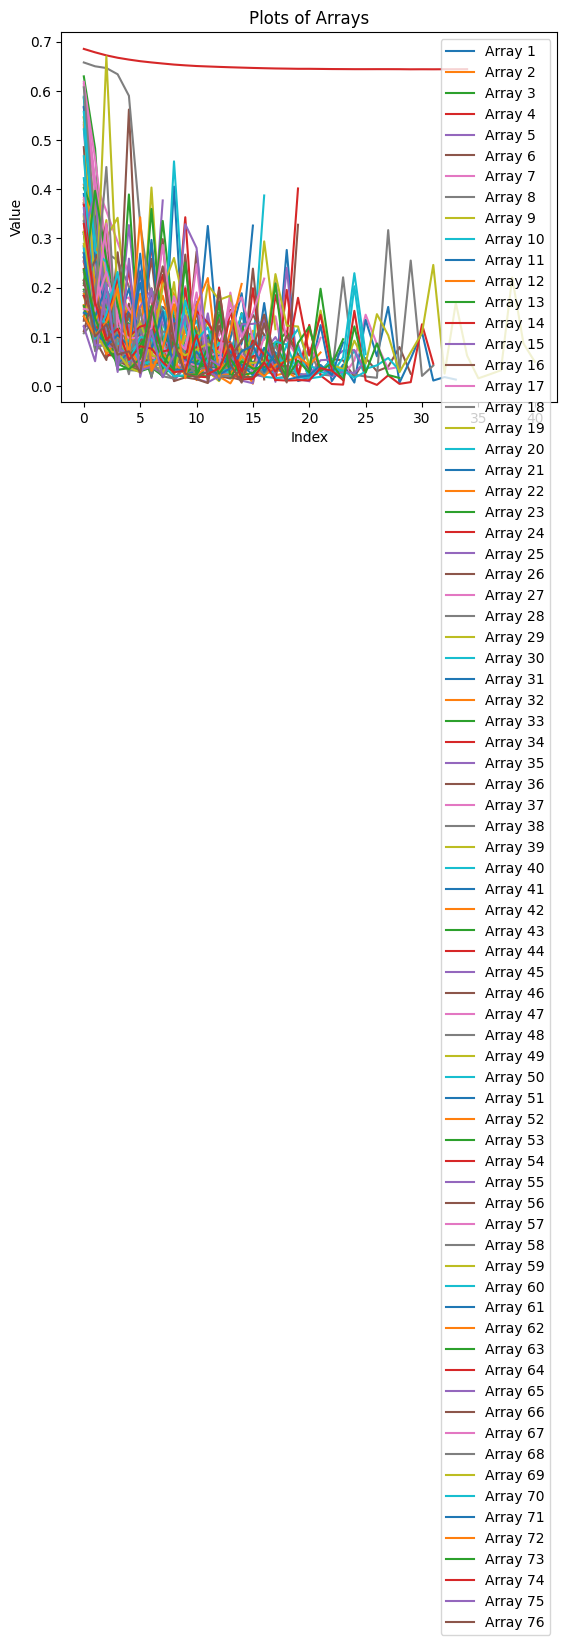

In [298]:
for i, sub_array in enumerate(all_val_losses, start=1):
    plt.plot(sub_array, label=f'Array {i}')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plots of Arrays')
plt.legend()

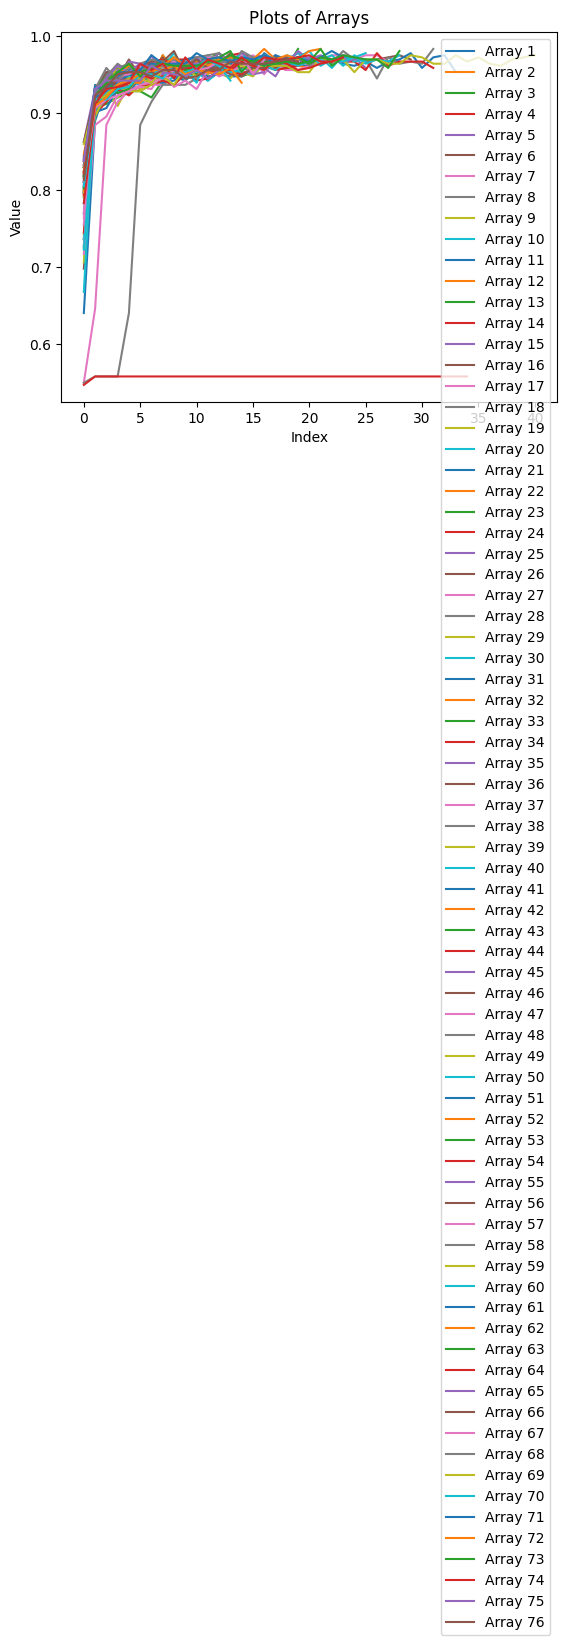

In [299]:
for i, sub_array in enumerate(all_accuracies, start=1):
    plt.plot(sub_array, label=f'Array {i}')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plots of Arrays')
plt.legend()

In [ ]:
# #create an individual

# def Individual():
#     n_layers = random.randint(1,4)
#     r_optimizer = random.choice([keras.optimizers.RMSprop(),'adam','sgd'])
#     neurons=[]
#     for i in range(n_layers):
#         neurons.append(random.randint(1,100))
#     neurons.sort(reverse=True)
#     model = Sequential()
#     model.add(Dense(30, input_dim=Input, activation='relu'))
#     for i in range(n_layers):
#         model.add(Dense(neurons[i], activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=r_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def create_population():
#     return [Individual() for _ in range(pupulation_size)]

# def evaluate(pupulation):
#     all_accuracies = []
#     all_val_losses = []
#     all_test_accuracies = []
#     es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#     for i in range(len(pupulation)):
#         metrics_history = MetricsHistory()
#         history = pupulation[i].fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=1, verbose=1, callbacks=[es,metrics_history])
#         pupulation[i].save(f'genetic_output_files/genetic_model_initial_individuals{i}.h5')
#         all_accuracies.append(metrics_history.accuracy)
#         all_val_losses.append(metrics_history.val_loss)
#         _, test_accuracy = pupulation[i].evaluate(x_test, y_test, verbose=0) 
#         all_test_accuracies.append(test_accuracy)
#     return all_test_accuracies,all_accuracies,all_val_losses

# def selection(population, fitnesses, num_parents):
#     """Selekcja najlepszych osobników do krzyżowania."""
#     sorted_indices = np.argsort(fitnesses)[::-1]
#     x = [population[i] for i in sorted_indices[:num_parents]]
#     parent_paths = []
#     for i in range(len(x)):
#         parent_paths.append("D:\\Studia\\ISA-magister\\sem_1\\Algorytmy_optymalizacji\\Projekt\\Repo\\nn-arc-optimization\\genetic\\genetic_output_files\\"+x[i])
        
#     return parent_paths

# # #calculate parents
# # num_parents = pupulation_size // 2


# #create a list with every acc and name od model

# # crossover
# def crossover(parent1_path, parent2_path):
#     # Wczytanie modeli rodziców
#     parent1 = keras.models.load_model(parent1_path)
#     parent2 = keras.models.load_model(parent2_path)
    
#     # Pobranie hiperparametrów z modeli rodziców
#     parent1_layers = parent1.layers
#     parent2_layers = parent2.layers
    
#     point1 = random.randint(1, min(len(parent1_layers), len(parent2_layers)) - 1)
#     point2 = random.randint(point1, min(len(parent1_layers), len(parent2_layers)) - 1)
    
#     child1_layers = [layer.get_config() for layer in parent1_layers]
#     child2_layers = [layer.get_config() for layer in parent2_layers]
    
#     for i in range(point1, point2):
#         child1_layers[i] = parent2_layers[i].get_config()
#         child2_layers[i] = parent1_layers[i].get_config()
        
#       # Creating new models
#     child1_model = Sequential()
#     child2_model = Sequential()
    
#     for layer_config in child1_layers:
#         layer = Dense.from_config(layer_config)
#         child1_model.add(layer)
    
#     for layer_config in child2_layers:
#         layer = Dense.from_config(layer_config)
#         child2_model.add(layer)
    
#     # Compiling new models
#     child1_model.compile(optimizer=parent1.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     child2_model.compile(optimizer=parent2.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     children = [child1_model, child2_model]
#     return child1_model, child2_model

# # Mutacja pojedynczego osobnika
# def mutate(individual, mutation_prob):
#     mutated_individual = []
#     for layer in individual.layers:
#         mutated_layer = layer
#         if random.random() < mutation_prob:
#             mutated_layer.set_weights([mutated_layer.get_weights()[0] + np.random.normal(0, 0.1, mutated_layer.get_weights()[0].shape),
#                                        mutated_layer.get_weights()[1] + np.random.normal(0, 0.1, mutated_layer.get_weights()[1].shape)])
#         mutated_individual.append(mutated_layer)
#     return mutated_individual


# # Tworzenie kolejnej generacji
# def create_next_generation(parents, population_size, mutation_prob):
#     next_generation = []
#     num_parents = len(parents)
#     while len(next_generation) < population_size:
#         parent1, parent2 = random.sample(parents, 2)
#         child1, child2 = crossover(parent1, parent2)
#         next_generation.append(mutate(child1, mutation_prob))
#         if len(next_generation) < population_size:
#             next_generation.append(mutate(child2, mutation_prob))
#     return next_generation


# #main code
# population = create_population()
# all_test_accuracies,all_accuracies,all_val_losses = evaluate(population)

# models_dir =  r"D:\Studia\ISA-magister\sem_1\Algorytmy_optymalizacji\Projekt\Repo\nn-arc-optimization\genetic\genetic_output_files"
# fitnesses = []
# files = os.listdir(models_dir)
# for i in range (len(files)):
#     fitnesses.append([test_accuracy[i],files[i]])
#     files.sort()
#     files = sorted(files, key=lambda x: int(x.split('.')[0].split('individuals')[-1]))
# num_parents = len(files)//2
    